In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from music21 import chord, note, stream, clef, meter
from data_cleaning import Open
import os
%matplotlib inline

In [2]:
mid_file1 = os.path.join(os.getcwd(), "progression1.mid")
midi_data1 = Open.open_midi(mid_file1)
mid_file2 = os.path.join(os.getcwd(), "progression2.mid")
midi_data2 = Open.open_midi(mid_file2)
concatenated_array = []

In [4]:
for i, part in enumerate(midi_data2.parts):
    for element in part.recurse():
        if isinstance(element, chord.Chord):
            concatenated_array.append(element)

In [5]:
all_chords = []
for chord in concatenated_array:
    chord_arr = []
    for notes in chord:
        chord_arr.append(notes.pitch.ps)
    all_chords.append(chord_arr)

flattened_list = [int(element)
                  for sublist in all_chords for element in sublist]
notes = sorted(set(flattened_list))
n_to_i = {s: i + 1 for i, s in enumerate(notes)}
n_to_i["."] = 0

i_to_n = {value: key for key, value in n_to_i.items()}

vocab_size = len(i_to_n)

In [ ]:
i_to_n

In [6]:
# shuffle up the words
import random

random.seed(42)
random.shuffle(all_chords)

In [18]:
# build the dataset
block_size = 8  # context length: how many characters do we take to predict the next one?


def build_dataset(n_chords):
    X, Y = [], []

    for notes in n_chords:
        context = [0] * block_size

        for n in notes + ["."]:
            ix = n_to_i[n]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(all_chords))
n2 = int(0.9*len(all_chords))
Xtr,  Ytr = build_dataset(all_chords[:n1])     # 80%
Xdev, Ydev = build_dataset(all_chords[n1:n2])   # 10%
Xte,  Yte = build_dataset(all_chords[n2:])     # 10%

torch.Size([786, 8]) torch.Size([786])
torch.Size([99, 8]) torch.Size([99])
torch.Size([106, 8]) torch.Size([106])


In [26]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print([i_to_n[ix.item()] for ix in x], "-->", i_to_n[y.item()])

['.', '.', '.', '.', '.', '.', '.', '.'] --> 45
['.', '.', '.', '.', '.', '.', '.', 45] --> 55
['.', '.', '.', '.', '.', '.', 45, 55] --> 57
['.', '.', '.', '.', '.', 45, 55, 57] --> 60
['.', '.', '.', '.', 45, 55, 57, 60] --> 64
['.', '.', '.', 45, 55, 57, 60, 64] --> .
['.', '.', '.', '.', '.', '.', '.', '.'] --> 41
['.', '.', '.', '.', '.', '.', '.', 41] --> 53
['.', '.', '.', '.', '.', '.', 41, 53] --> 57
['.', '.', '.', '.', '.', 41, 53, 57] --> 60
['.', '.', '.', '.', 41, 53, 57, 60] --> .
['.', '.', '.', '.', '.', '.', '.', '.'] --> 43
['.', '.', '.', '.', '.', '.', '.', 43] --> 55
['.', '.', '.', '.', '.', '.', 43, 55] --> 59
['.', '.', '.', '.', '.', 43, 55, 59] --> 62
['.', '.', '.', '.', 43, 55, 59, 62] --> .
['.', '.', '.', '.', '.', '.', '.', '.'] --> 48
['.', '.', '.', '.', '.', '.', '.', 48] --> 55
['.', '.', '.', '.', '.', '.', 48, 55] --> 60
['.', '.', '.', '.', '.', 48, 55, 60] --> 64


In [76]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / \
            fan_in**0.5 +0.01 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------


class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [77]:
torch.manual_seed(42)  # seed rng for reproducibility

In [85]:
# hierarchical network
n_embd = 16  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

19736


In [86]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 1.5 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x32 and 16x64)

In [54]:
del lossi[-67:]

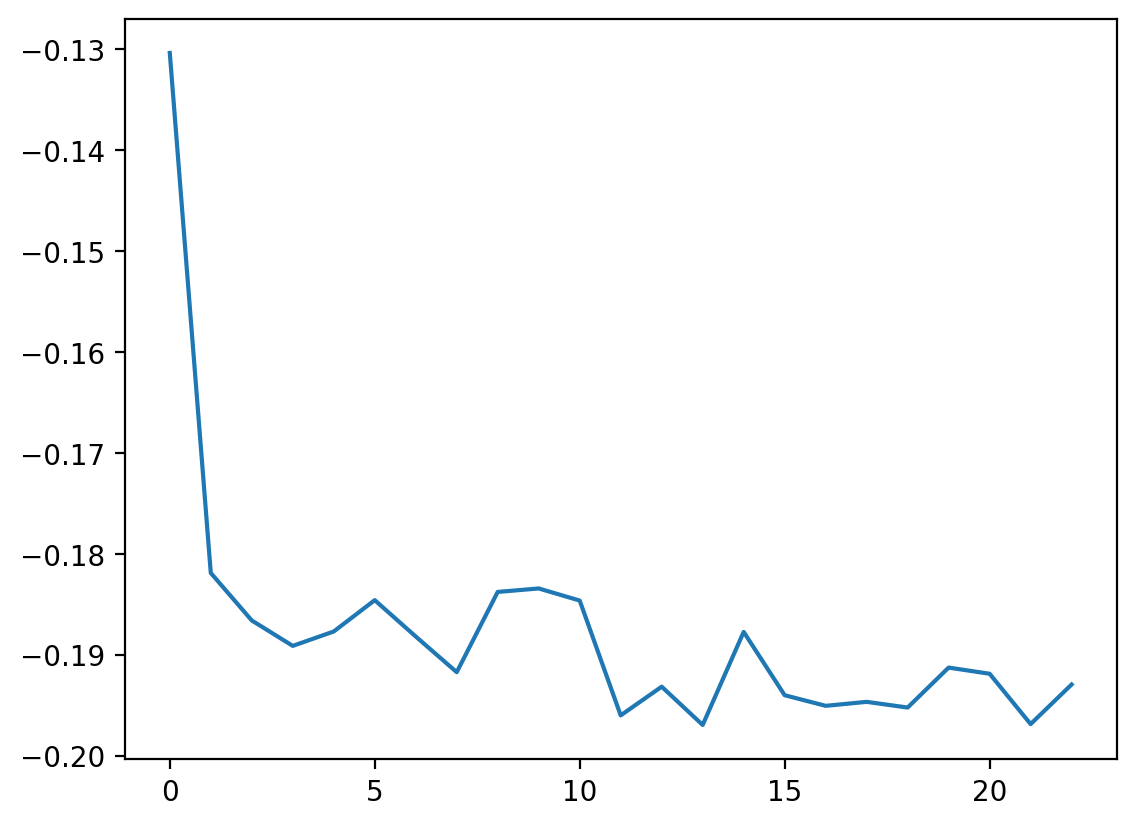

In [55]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936515092849731


### performance log

-   original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
-   context: 3 -> 8 (22K params): train 1.918, val 2.027
-   flat -> hierarchical (22K params): train 1.941, val 2.029
-   fix bug in batchnorm: train 1.912, val 2.022
-   scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [ ]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print("".join(i_to_n[i] for i in out))

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


### Next time:

Why convolutions? Brief preview/hint


In [ ]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7 + i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space